# Disease-state discovery on HLCA - DE analysis between basal-like aberrant cells

In this analysis we characterize aberrant basal-like cells identified with disease state detection analysis using ACR design (see ``HLCA_design_comparison.ipynb`)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import oor_benchmark

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sc.set_figure_params(scanpy=True, fontsize=14)

In [2]:
import milopy

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [6]:
from adjustText import adjust_text
def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [7]:
import matplotlib

def plot_milo_diagnostics(nhood_adata, alpha = 0.1, figsize=[12, 12]):
    with matplotlib.rc_context({"figure.figsize": figsize}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(nhood_adata.obs["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(nhood_adata.obs["PValue"], nhood_adata.obs["SpatialFDR"], s=3)
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            nhood_adata.obs["logFC"], -np.log10(nhood_adata.obs["SpatialFDR"]), s=3
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = nhood_adata.obs
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()

In [8]:
def _get_cells_in_nhoods(adata, nhood_ids):
    """Get cells in neighbourhoods of interest, store the number of neighbourhoods for each cell in adata.obs['in_nhoods']"""
    in_nhoods = np.array(adata.obsm["nhoods"][:, nhood_ids.astype("int")].sum(1))
    adata.obs["in_nhoods"] = (in_nhoods > 0).astype('int')
    adata.obs["in_nhoods"] = in_nhoods 

In [9]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [10]:
import os
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/HLCA_IPF_analysis/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [11]:
%%R -i design_palette_df -i figdir
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

## Load milo results with ACR design

In [12]:
data_dir = '/lustre/scratch126/cellgen/team205/ed6/HLCA/'

In [13]:
acr_adata = sc.read_h5ad(data_dir + "Kaminski_2020_oor_design.ACR.h5ad")
acr_adata.uns["nhood_adata"] = sc.read_h5ad(data_dir + "Kaminski_2020_oor_design.ACR.nhood_adata.h5ad")

In [14]:
acr_adata.var = acr_adata.var.set_index("gene_name")

In [15]:
acr_adata.var['gene_name'] = acr_adata.var_names.copy()

In [16]:
all_cts = acr_adata.obs['Celltype_HLCA'].unique().tolist()
all_cts.sort()

ct_groups = {}
ct_groups['macrophages'] = [x for x in all_cts if 'macro' in x or 'Mφ' in x]
ct_groups['fibroblasts'] = [x for x in all_cts if 'fibroblast' in x]
ct_groups['basal'] = [x for x in all_cts if 'basal' in x or "Basal" in x]
ct_groups['AT'] = [x for x in all_cts if "AT" in x]
ct_groups['EC'] = [x for x in all_cts if "EC" in x]
ct_groups['Club'] = [x for x in all_cts if "Club" in x]
ct_groups['Goblet'] = [x for x in all_cts if "Goblet" in x]
ct_groups['SMG'] = [x for x in all_cts if "SMG" in x]
ct_groups['Multiciliated'] = [x for x in all_cts if "Multiciliated" in x]

ct_groups['Lymphoid'] = ['B cells',
 'CD4 T cells',
 'CD8 T cells',
  'NK cells',
'Plasma cells',
 'T cells proliferating']
    
ct_groups['Myeloid'] = [
 'Mast cells',
'Classical monocytes',
 'DC1',
 'DC2',
 'Migratory DCs',
 'Non-classical monocytes',
 'Plasmacytoid DCs'    
]
 
min_cells = 10

ct_groups_rev = {x:k for k,v in ct_groups.items() for x in v}
for ct in all_cts:
    if sum(acr_adata.obs['Celltype_HLCA'] == ct) < min_cells:
        ct_groups_rev[ct] = np.nan
    else:        
        if ct not in ct_groups_rev.keys():
            ct_groups_rev[ct] = ct


In [17]:
## Annotate nhoods by cell type
milopy.utils.annotate_nhoods(acr_adata, anno_col='Celltype_HLCA')
acr_adata.uns['nhood_adata'].obs['nhood_annotation_group'] = [ct_groups_rev[x] for x in acr_adata.uns['nhood_adata'].obs['nhood_annotation']]

In [18]:
acr_adata.obs['ct_group'] = [ct_groups_rev[ct] for ct in acr_adata.obs['Celltype_HLCA']]

### Define aberrant phenotypes

In [19]:
# Nhood IDs (annotated w exploratory analysis of IPF diagnostic signature)
enr_basal = '219'
basaloid = '796'

In [20]:
acr_adata.obs['nhood_groups'] = 'other'
nhood_groups = {"KRT17hi_basal":enr_basal, "Basaloid":basaloid}
for k,gr in nhood_groups.items():
    _get_cells_in_nhoods(acr_adata, pd.Series(gr))
    acr_adata.obs.loc[acr_adata.obs['in_nhoods'] == 1, 'nhood_groups'] = k

acr_adata.obs.loc[(acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'])) & (acr_adata.obs['nhood_groups'] == 'other'), 'nhood_groups'] = 'Normal_basal'

In [21]:
acr_adata.obs['nhood_groups'] = acr_adata.obs['nhood_groups'].astype("category").cat.reorder_categories(['other', 'Normal_basal', 'Basaloid', 'KRT17hi_basal'])

In [22]:
acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'] + ct_groups['AT'])].obs[['nhood_groups', 'Celltype_HLCA']].value_counts()

nhood_groups   Celltype_HLCA        
other          AT2                      4426
               AT1                      1298
               Transitional Club-AT2    1046
Normal_basal   Basal resting             882
               Suprabasal                680
KRT17hi_basal  Suprabasal                287
Basaloid       AT2                       234
KRT17hi_basal  Basal resting              62
Basaloid       Suprabasal                 44
               AT1                        21
               Basal resting               1
dtype: int64

In [23]:
acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'] + ct_groups['AT'])].obs[['nhood_groups', 'disease']].value_counts()

nhood_groups   disease
other          Control    3254
               IPF        1947
               COPD       1569
Normal_basal   IPF        1228
KRT17hi_basal  IPF         338
Basaloid       IPF         280
Normal_basal   COPD        171
               Control     163
Basaloid       COPD         18
KRT17hi_basal  Control       7
               COPD          4
Basaloid       Control       2
dtype: int64

In [27]:
acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'] + ct_groups['AT'])].obs[[ 'disease', 'individual']].drop_duplicates().value_counts('disease')

disease
IPF        32
Control    28
COPD       18
dtype: int64

In [ ]:
acr_adata.layers['counts'] = acr_adata.X.copy()

sc.pp.normalize_total(acr_adata, target_sum=10000)
sc.pp.log1p(acr_adata)

In [ ]:
basaloid_markers_adams = 'EPCAM CDH1 VIM FN1 COL1A1 CDH2 TNC VCAN PCP4 CUX2 SPINK1 PRSS2 CPA6 CTSE MMP7 MDK GDF15 PTGS2 SLCO2A1 EPHB2 ITGB8 ITGAV ITGB6 TGFBI KCNN4 KCNQ5 KCNS3 CDKN1A CDKN2A CDKN2B CCND1 CCND2 MDM2 HMGA2 PTCHD4 OCIAD2'
basaloid_markers_adams = basaloid_markers_adams.split(' ')

In [ ]:
acr_adata.obs['nhood_groups'] = acr_adata.obs['nhood_groups'].cat.reorder_categories(['other', 'Normal_basal', 'KRT17hi_basal', 'Basaloid'])

sc.pl.dotplot(acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'])], 
              {'basal\nmarkers':['KRT5', 'KRT17'], 
               'basaloid':basaloid_markers_adams,
               'KRT17hi aberrant basal':['FOSL1','MYC','KLF4', 'AREG', "CTGF", 'ADAM9', "ITGB8", 'ITGB6', 'HBEGF', 'CD24', 'KRT6A', 'ADAM17'],
#                'GWAS':['MUC5B', "AKAP13", "DSP"]
              }, cmap='magma_r',var_group_rotation=0, figsize=(13,2.2),colorbar_title='Mean expression',
              groupby='nhood_groups', vmin=0, show=False)
plt.savefig(figdir + 'basal_markers_dotplot.pdf', bbox_inches='tight');
plt.show()

In [ ]:
n_cells = acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'])].obs.groupby(['nhood_groups', 'disease', 'individual']).size().reset_index()
n_cells['n_cells'] = n_cells[0]

pal = sns.color_palette('Paired').as_hex()
disease_palette = {'Control':pal[1], 'IPF':pal[4], 'COPD':'grey'}
disease_palette

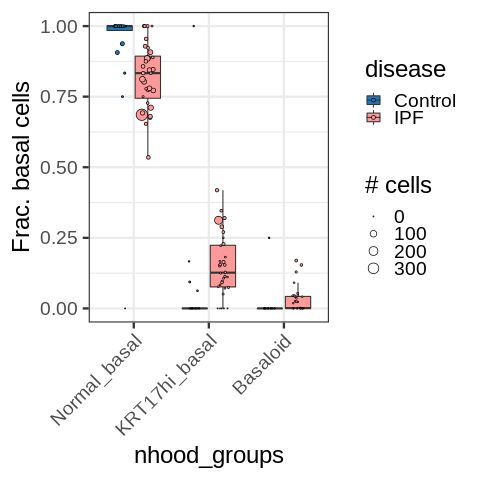

In [88]:
%%R -i n_cells
n_cells %>%
filter(disease!='COPD') %>%
group_by(individual, disease) %>%
mutate(frac_cells=n_cells/sum(n_cells)) %>%
ungroup() %>%
ggplot(aes(nhood_groups, frac_cells, fill=disease)) +
geom_boxplot(outlier.alpha=0) +
geom_point(position=position_jitterdodge(), aes(size=n_cells), shape=21) +
scale_size(range=c(0.2,5), name='# cells') +
theme_bw(base_size=24) +
scale_fill_manual(values = c(Control='#1f78b4', IPF='#fb9a99')) +
ylab("Cell phenotype") + ylab('Frac. basal cells') +
theme(axis.text.x=element_text(angle=45, vjust=1, hjust=1)) +
ggsave(paste0(figdir, 'basal_phenotype_fraction_boxplot.pdf'), width=6, height=6) +
ggsave(paste0(figdir, 'basal_phenotype_fraction_boxplot.png'), width=6, height=6) 

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


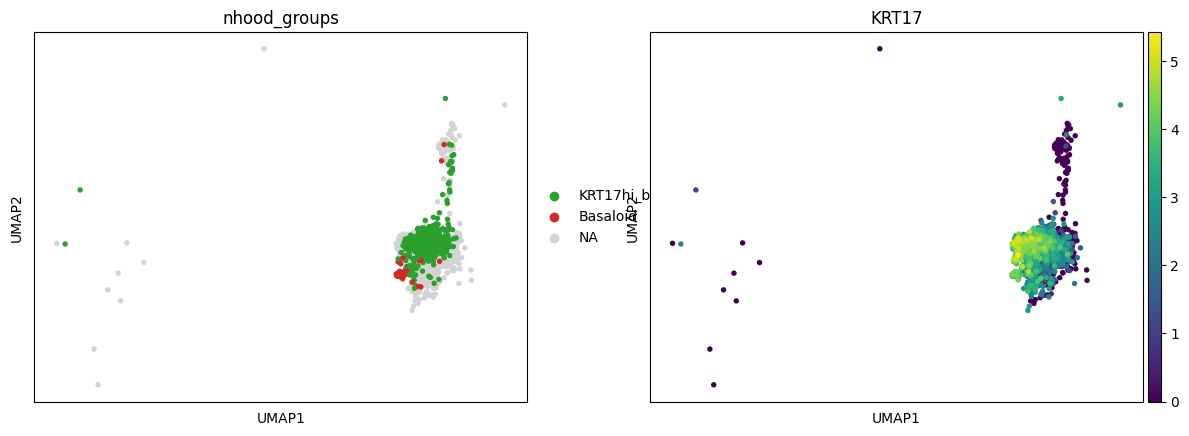

In [54]:
sc.pl.umap(acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'])], 
           color=['nhood_groups', 'KRT17'], groups=['KRT17hi_basal', 'Basaloid'])

In [59]:
epi_adata = acr_adata[
    (acr_adata.obs['ct_group'].isin(['basal', 'AT', 'Goblet', 'Multiciliated'])) 
#     & 
#     (acr_adata.obs['Celltype_HLCA'] != 'Multiciliated (non-nasal)')
].copy()

In [61]:
sc.pp.neighbors(epi_adata, use_rep='X_scVI', n_neighbors=50)
sc.tl.umap(epi_adata)

2023-01-27 16:35:40.599053: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server:/usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server
2023-01-27 16:35:40.856861: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-27 16:35:46.851833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server:/us

In [71]:
epi_adata.obs['nhood_groups'] = acr_adata[epi_adata.obs_names].obs['nhood_groups']

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


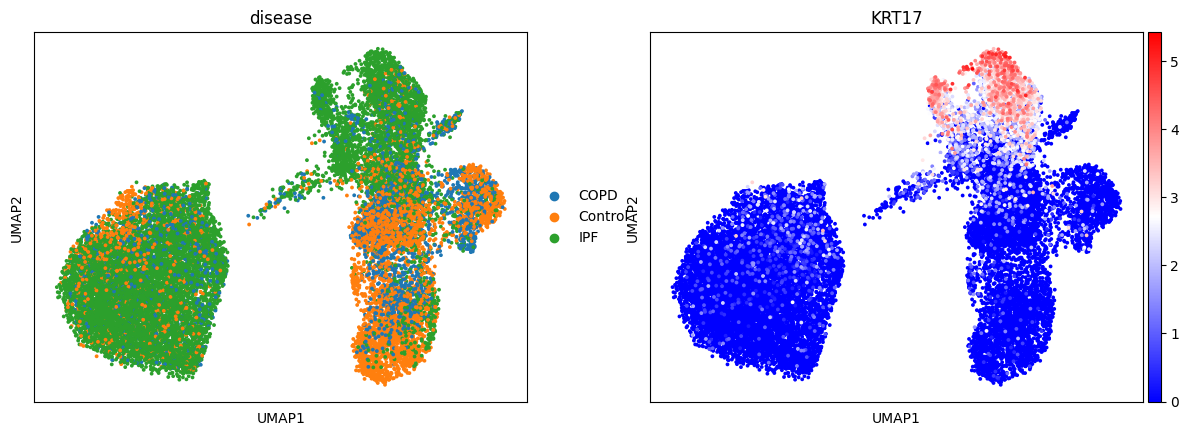

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


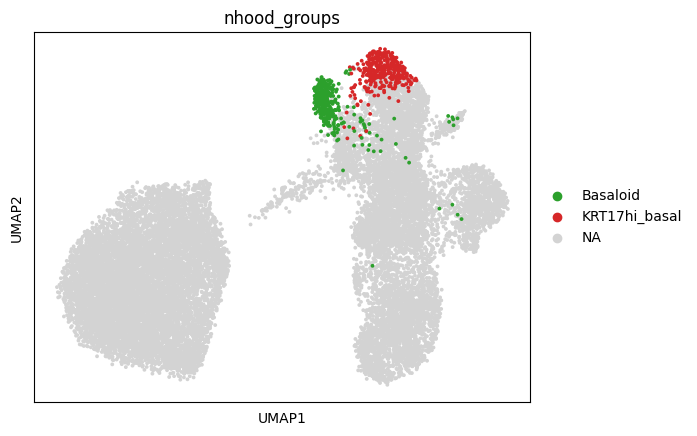

In [77]:
sc.pl.umap(epi_adata, color=['disease', "KRT17"], cmap='bwr',size=30, ncols=2)
sc.pl.umap(epi_adata, color=['nhood_groups'], cmap='bwr',size=30, ncols=2, groups=['Basaloid', 'KRT17hi_basal'])

### Run differential expression analysis

Helper functions

In [29]:
import diff2atlas
import os

def run_glmGamPoi_DE(pbulk_adata, 
                     design = '~ Site + nhood_groups',
                    ref_level = 'in_nhoods_other',
                    contrast = 'nhood_groupsin_nhoods_critical',
                     n_hvgs = 5000):
    '''
    Run R code for DE analysis with glmGamPoi
    
    Params:
    ------
    - pbulk_adata: anndata object with pseudobulked data
    
    '''
    
    ## Define R function
    glmgampoi_str = f'''
        library(SingleCellExperiment)
        library(glmGamPoi)
        library(scran)
        library(scater)

        run_de <- function(args){{
            pbulk_sdata_X <- args[[1]]
            pbulk_sdata_obs <- args[[2]]
            pbulk_sdata_var <- args[[3]]
            n_hvgs <- args[[4]]

            sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)
            sce <- logNormCounts(sce)

            ## Feature selection w scran (just on test cell types)
            dec <- modelGeneVar(sce)
            hvgs <- getTopHVGs(dec, n = n_hvgs)
            subset_sce <- sce[hvgs,]

            ## Fit
            fit <- glm_gp(subset_sce, design = {design}, reference_level = '{ref_level}')

            ## Test 
            de_res <- test_de(fit, contrast = '{contrast}')    
            de_res[,'gene_name'] <- pbulk_sdata_var[hvgs,]['gene_name']
            return(de_res)
        }}'''
    
    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP
    
    ## Get anndata components
    pbulk_sdata_X = pbulk_adata.X.toarray().copy()
    pbulk_sdata_obs = pbulk_adata.obs.copy()
    pbulk_sdata_var = pbulk_adata.var.copy()
    
    r_pkg = STAP(glmgampoi_str, "r_pkg")
    # this was needed for the code to run on jhub
    # if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    args = [pbulk_sdata_X, pbulk_sdata_obs, pbulk_sdata_var, n_hvgs]
    de_res_df = r_pkg.run_de(args).to_csvfile('./DE_results.csv')
    de_res_df = pd.read_csv('./DE_results.csv', index_col=0)
    de_res_df.index = de_res_df['gene_name']
    de_res_df.drop('name', 1, inplace=True)
    os.remove('./DE_results.csv')
    return(de_res_df)

def find_nhood_group_markers(
    adata, 
    test_group: str,
    ctrl_group: str,
    confounders_obs = None,
    nhood_group_obs: str = 'nhood_groups',
    min_n_nhoods: int = 3,
    pbulk_use_layer: str = None,
    n_hvgs: int = 5
    ):
    '''
    Find genes differentially expressed between cells in 2 groups of neighbourhoods
    
    Params:
    -------
    - adata: AnnData object storing nhood info in adata.uns['nhood_adata']
    - design: design formula for the test, passed to glmGamPoi
    - test_group: which neighbourhood group is the test group?
    - ctrl_group: which neighbourhood group is the reference group?
    - nhood_group_obs: the column in adata.uns['nhood_adata'] storing the neighbourhood group information
    - min_n_nhoods: cells are assigned to a neighbourhood group only if it belongs to at least min_n_nhoods neighbourhoods in the group
    - pbulk_use_layer: layer storing counts (if None, adata.X is used) 
    - n_hvgs: how many HVGS to use for the DE test (the more you use, the longer it takes)
    
    Returns:
    --------
    pd.DataFrame storing DE test results
    '''

    ## Make pseudobulk adata for cells if different nhood groups and samples
    sdata = adata[~adata.obs['nhood_groups'].isna()].copy()
    if confounders_obs is None:
        design = '~ nhood_groups'
        pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[adata.uns['nhood_adata'].uns['sample_col'], 'nhood_groups'], 
            min_ncells=1, 
            use_layer=pbulk_use_layer)
    else:
        if isinstance(confounders_obs, str):
            confounder_obs = [confounders_obs]
        design = "~ " + ' + '.join(confounders_obs) + ' + nhood_groups'
        pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[nhood_adata.uns['sample_col'], 'nhood_groups'] + confounders_obs, 
            min_ncells=1, 
            use_layer=pbulk_use_layer)
    
    pbulk_sdata.var = adata.var.copy() 
    de_results = run_glmGamPoi_DE(pbulk_sdata, design=design, 
                           ref_level = f'{ctrl_group}', 
                           contrast = f'nhood_groups{test_group}', 
                           n_hvgs=n_hvgs)
    return(de_results)

Global seed set to 0
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [321]:
## Exclude genes for testing
sc.pp.calculate_qc_metrics(acr_adata, inplace=True)
tot_counts = acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'] + ct_groups['AT'])].X.sum(0)
test_var_names = acr_adata.var_names[
    (acr_adata.var['n_cells_by_counts']/acr_adata.n_obs < 0.5) & # exclude ubiquitously expressed
    (np.array(tot_counts).ravel() >= 5) # exclude lowly expressed
]

#### Compare aberrant states vs normal basal cells

In [392]:
## Run DE testing
DE_KRT17hi_vs_normal = find_nhood_group_markers(
    acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'] + ct_groups['AT'])][:,test_var_names], 
    test_group='KRT17hi_basal', 
    ctrl_group='Normal_basal', 
    n_hvgs = 7500,
    pbulk_use_layer='counts'
    )


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_1924/1493349435.py:68: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)


In [393]:
DE_Basaloid_vs_normal = find_nhood_group_markers(
    acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'] + ct_groups['AT'])][:,test_var_names], 
    test_group='Basaloid', 
    ctrl_group='Normal_basal', 
    n_hvgs = 7500,
    pbulk_use_layer='counts'
    )


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_1924/1493349435.py:68: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


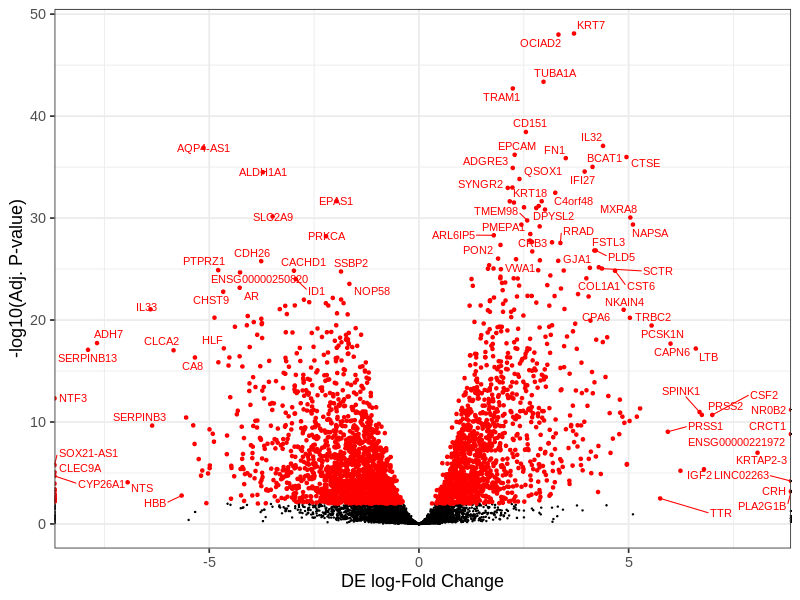

In [394]:
%%R -i DE_Basaloid_vs_normal -w 800 -h 600 -o DE_Basaloid_vs_normal
max_lfc = 15
DE_Basaloid_vs_normal$lfc <- ifelse(abs(DE_Basaloid_vs_normal$lfc) > max_lfc, sign(DE_Basaloid_vs_normal$lfc) * Inf, DE_Basaloid_vs_normal$lfc)
DE_Basaloid_vs_normal %>%
#     filter(contrast == 'mild_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.75), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(size=0.5) +
    geom_point(data=. %>% filter(signif), color='red') +
    ggrepel::geom_text_repel(aes(label=label), color='red') +
    theme_bw(base_size=18) +
    xlab("DE log-Fold Change") +
    ylab('-log10(Adj. P-value)') 
#     ggsave(paste0(figdir, 'volcano_CD14_monos.png'), height=7, width=7) +
#     ggsave(paste0(figdir, 'volcano_CD14_monos.pdf'), height=7, width=7) 

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


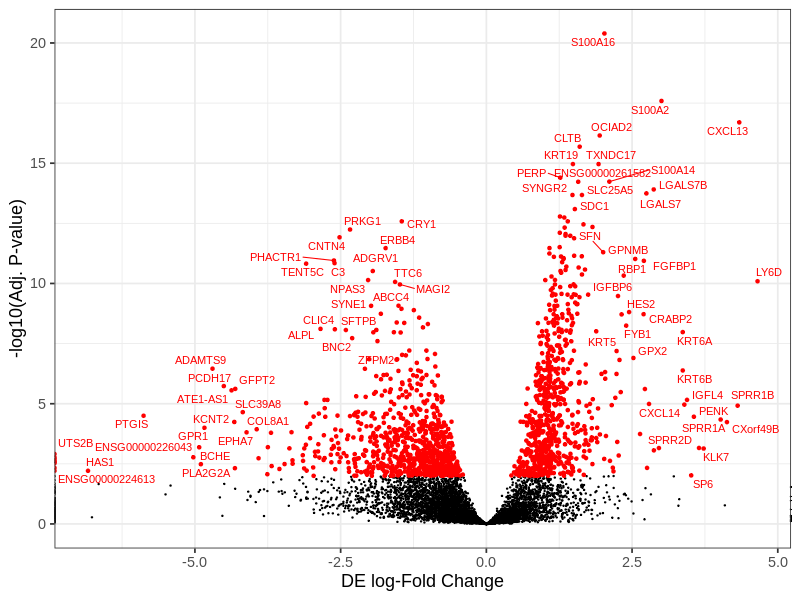

In [395]:
%%R -i DE_KRT17hi_vs_normal -w 800 -h 600 -o DE_KRT17hi_vs_normal
max_lfc = 15
DE_KRT17hi_vs_normal$lfc <- ifelse(abs(DE_KRT17hi_vs_normal$lfc) > max_lfc, sign(DE_KRT17hi_vs_normal$lfc) * Inf, DE_KRT17hi_vs_normal$lfc)
DE_KRT17hi_vs_normal %>%
#     filter(contrast == 'mild_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.75), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(size=0.5) +
    geom_point(data=. %>% filter(signif), color='red') +
    ggrepel::geom_text_repel(aes(label=label), color='red') +
    theme_bw(base_size=18) +
    xlab("DE log-Fold Change") +
    ylab('-log10(Adj. P-value)') 
#     ggsave(paste0(figdir, 'volcano_CD14_monos.png'), height=7, width=7) +
#     ggsave(paste0(figdir, 'volcano_CD14_monos.pdf'), height=7, width=7) 

In [396]:
DE_Basaloid_vs_normal['comparison'] = 'Basaloid_vs_normal'
DE_KRT17hi_vs_normal['comparison'] = 'KRT17hi_vs_normal'

In [397]:
lfc_df = pd.concat([DE_KRT17hi_vs_normal, DE_Basaloid_vs_normal])[['lfc', 'gene_name', 'comparison']].pivot(index='gene_name', values='lfc', columns='comparison')
fdr_df = pd.concat([DE_KRT17hi_vs_normal, DE_Basaloid_vs_normal])[['adj_pval', 'gene_name', 'comparison']].pivot(index='gene_name', values='adj_pval', columns='comparison')

In [398]:
alpha = 0.1
lfc_df['signif_group'] = 'other'
lfc_df.loc[(fdr_df['Basaloid_vs_normal'] < alpha) & (fdr_df['KRT17hi_vs_normal'] < alpha) &
           (lfc_df['Basaloid_vs_normal'] > 0) & (lfc_df['KRT17hi_vs_normal'] > 0), 
           'signif_group'] = 'enr_both'
lfc_df.loc[(fdr_df['Basaloid_vs_normal'] >= alpha) & (fdr_df['KRT17hi_vs_normal'] < alpha) &
           (lfc_df['Basaloid_vs_normal'] < 0) & (lfc_df['KRT17hi_vs_normal'] > 0), 
           'signif_group'] = 'enr_KRT17hi'
lfc_df.loc[(fdr_df['Basaloid_vs_normal'] < alpha) & (fdr_df['KRT17hi_vs_normal'] >= alpha) &
                      (lfc_df['Basaloid_vs_normal'] > 0) & (lfc_df['KRT17hi_vs_normal'] < 0), 
           'signif_group'] = 'enr_Basaloid'
lfc_df

comparison,Basaloid_vs_normal,KRT17hi_vs_normal,signif_group
gene_name,,,
A2M,-0.180051,-0.275862,other
A2MP1,0.517779,0.539290,other
A4GALT,-2.140910,0.655748,other
AACSP1,-2.673203,-2.084202,other
AADAC,-1.875612,-0.954930,other
...,...,...,...
ZSCAN31,-1.134108,-0.567028,other
ZSWIM4,-0.725843,-0.200199,other
ZSWIM5,-0.918422,-0.963548,other


### Compare basaloid vs KRT17hi aberrant basal

In [492]:
DE_Basaloid_vs_KRT17hi = find_nhood_group_markers(
    acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'] + ct_groups['AT'])][:,test_var_names], 
    test_group='Basaloid', 
    ctrl_group='KRT17hi_basal', 
    n_hvgs = 7500,
    pbulk_use_layer='counts'
    )

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_1924/1493349435.py:68: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


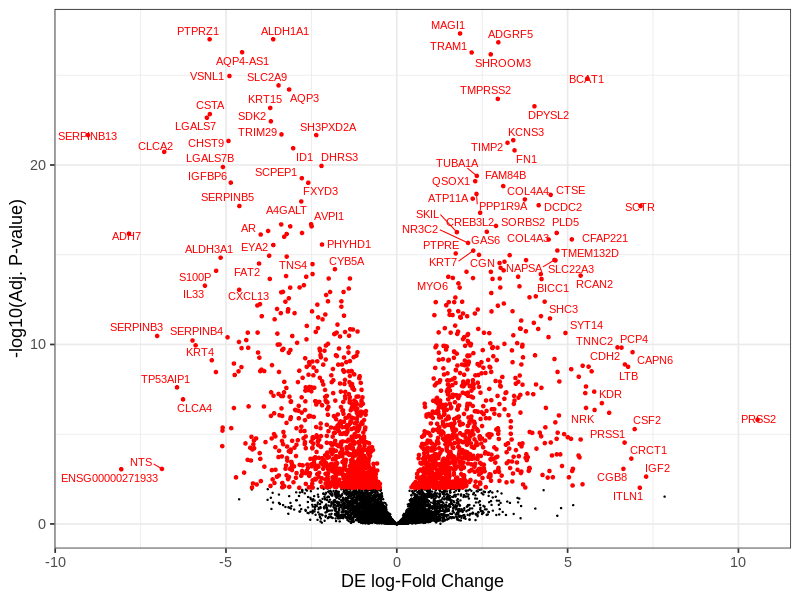

In [80]:
%%R -i DE_Basaloid_vs_KRT17hi -w 800 -h 600 -o DE_Basaloid_vs_KRT17hi
max_lfc = 15
DE_Basaloid_vs_KRT17hi$lfc <- ifelse(abs(DE_Basaloid_vs_KRT17hi$lfc) > max_lfc, sign(DE_Basaloid_vs_KRT17hi$lfc) * Inf, DE_Basaloid_vs_KRT17hi$lfc)
DE_Basaloid_vs_KRT17hi %>%
#     filter(contrast == 'mild_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.75), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(size=0.5) +
    geom_point(data=. %>% filter(signif), color='red') +
    ggrepel::geom_text_repel(aes(label=label), color='red') +
    theme_bw(base_size=18) +
    xlab("DE log-Fold Change") +
    ylab('-log10(Adj. P-value)') 
#     ggsave(paste0(figdir, 'volcano_CD14_monos.png'), height=7, width=7) +
#     ggsave(paste0(figdir, 'volcano_CD14_monos.pdf'), height=7, width=7) 

In [508]:
DE_Basaloid_vs_KRT17hi = DE_Basaloid_vs_KRT17hi[~np.isinf(DE_Basaloid_vs_KRT17hi['lfc'])]

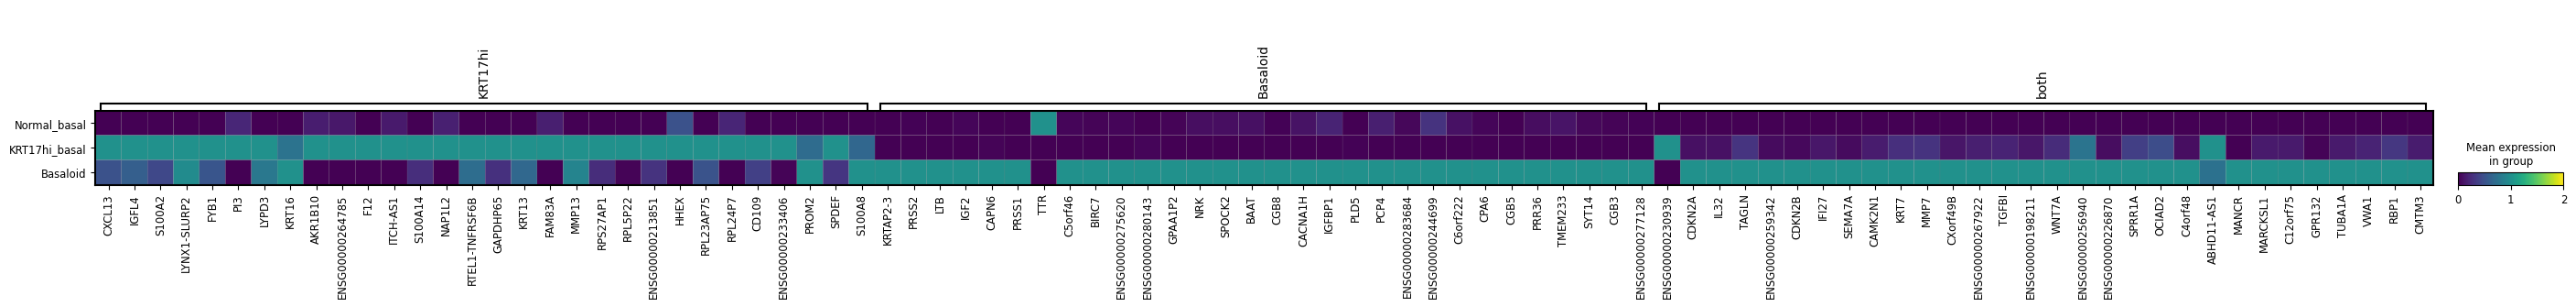

In [527]:
DE_markers = {
    'enr_basaloid':DE_Basaloid_vs_KRT17hi[(DE_Basaloid_vs_KRT17hi.adj_pval < 0.01) & (DE_Basaloid_vs_KRT17hi.lfc > 3)].sort_values("lfc", ascending=False)[0:40].index,
    'enr_KRT17hi':DE_Basaloid_vs_KRT17hi[(DE_Basaloid_vs_KRT17hi.adj_pval < 0.01) & (DE_Basaloid_vs_KRT17hi.lfc < -3)].sort_values("lfc", ascending=False)[0:40].index
}

DE_markers = {"KRT17hi":lfc_df[(lfc_df['signif_group'] == 'enr_KRT17hi') & (lfc_df['KRT17hi_vs_normal'] > 1)].sort_values('KRT17hi_vs_normal', ascending=False)[0:30].index,
"Basaloid":lfc_df[(lfc_df['signif_group'] == 'enr_Basaloid') & (lfc_df['Basaloid_vs_normal'] > 3)].sort_values('Basaloid_vs_normal', ascending=False)[0:30].index,
"both":lfc_df[(lfc_df['signif_group'] == 'enr_both') & (lfc_df['Basaloid_vs_normal'] > 2)].sort_values('Basaloid_vs_normal', ascending=False)[0:30].index}

sc.pl.matrixplot(acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'])], DE_markers,standard_scale='var',
              groupby='nhood_groups', vmin=0, vmax=2)

In [577]:
DE_Basaloid_vs_KRT17hi['signif'] = np.nan
DE_Basaloid_vs_KRT17hi.loc[:,'signif'] = np.where((DE_Basaloid_vs_KRT17hi['lfc'] > 0) & (DE_Basaloid_vs_KRT17hi['adj_pval'] < 0.01), 'enr_Basaloid', DE_Basaloid_vs_KRT17hi['signif'])
DE_Basaloid_vs_KRT17hi.loc[:,'signif'] = np.where((DE_Basaloid_vs_KRT17hi['lfc'] < 0) & (DE_Basaloid_vs_KRT17hi['adj_pval'] < 0.01), 'enr_KRT17hi', DE_Basaloid_vs_KRT17hi['signif'])

enr_KRT17hi_vs_normal = DE_KRT17hi_vs_normal.gene_name[(DE_KRT17hi_vs_normal.adj_pval < 0.01) & (DE_KRT17hi_vs_normal.lfc > 0)]
enr_Basaloid_vs_normal = DE_Basaloid_vs_normal.gene_name[(DE_Basaloid_vs_normal.adj_pval < 0.01) & (DE_Basaloid_vs_normal.lfc > 0)]

DE_Basaloid_vs_KRT17hi['signif_vs_normal'] = np.nan
DE_Basaloid_vs_KRT17hi.loc[(DE_Basaloid_vs_KRT17hi['signif'] == 'enr_KRT17hi') & (DE_Basaloid_vs_KRT17hi.gene_name.isin(enr_KRT17hi_vs_normal)), 'signif_vs_normal'] = 'enr_KRT17hi'
DE_Basaloid_vs_KRT17hi.loc[(DE_Basaloid_vs_KRT17hi['signif'] == 'enr_Basaloid') & (DE_Basaloid_vs_KRT17hi.gene_name.isin(enr_Basaloid_vs_normal)), 'signif_vs_normal'] = 'enr_Basaloid'

/tmp/ipykernel_1924/2622689482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_Basaloid_vs_KRT17hi['signif'] = np.nan
/tmp/ipykernel_1924/2622689482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_Basaloid_vs_KRT17hi.loc[:,'signif'] = np.where((DE_Basaloid_vs_KRT17hi['lfc'] > 0) & (DE_Basaloid_vs_KRT17hi['adj_pval'] < 0.01), 'enr_Basaloid', DE_Basaloid_vs_KRT17hi['signif'])
/tmp/ipykernel_1924/2622689482.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [578]:
DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_KRT17hi'].sort_values('lfc')[0:50]

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,signif,signif_vs_normal,drug_targets
SERPINB13,5.756759e-25,2.158785e-22,128.831611,1,291.127484,-9.039401,SERPINB13,enr_KRT17hi,enr_KRT17hi,False
CLCA2,6.401703e-24,1.846645e-21,121.992274,1,291.127484,-6.807423,CLCA2,enr_KRT17hi,enr_KRT17hi,False
SERPINB4,1.635200e-12,6.011765e-11,54.507138,1,291.127484,-5.979008,SERPINB4,enr_KRT17hi,enr_KRT17hi,False
LGALS7,4.978221e-26,2.333541e-23,135.900872,1,291.127484,-5.558895,LGALS7,enr_KRT17hi,enr_KRT17hi,False
CSTA,2.917727e-26,1.458863e-23,137.459897,1,291.127484,-5.472791,CSTA,enr_KRT17hi,enr_KRT17hi,False
ALDH3A1,1.371771e-17,1.469755e-15,82.982292,1,291.127484,-5.156967,ALDH3A1,enr_KRT17hi,enr_KRT17hi,False
LGALS7B,4.857456e-23,1.301104e-20,116.326838,1,291.127484,-5.090279,LGALS7B,enr_KRT17hi,enr_KRT17hi,False
GJB5,1.059486e-12,3.973073e-11,55.521410,1,291.127484,-4.954022,GJB5,enr_KRT17hi,enr_KRT17hi,False
VSNL1,1.173182e-28,1.099858e-25,153.900347,1,291.127484,-4.900418,VSNL1,enr_KRT17hi,enr_KRT17hi,False
IGFBP6,4.102320e-22,9.614813e-20,110.448349,1,291.127484,-4.859640,IGFBP6,enr_KRT17hi,enr_KRT17hi,False


In [579]:
DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_Basaloid'].sort_values('lfc')[0:50]

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,signif,signif_vs_normal,drug_targets
NUDC,2.624123e-03,9.786636e-03,9.210172,1,291.127484,0.522168,NUDC,enr_Basaloid,enr_Basaloid,False
CHMP2B,1.298245e-03,5.412362e-03,10.549389,1,291.127484,0.566025,CHMP2B,enr_Basaloid,enr_Basaloid,False
MPZL1,2.380298e-03,9.033359e-03,9.394621,1,291.127484,0.575755,MPZL1,enr_Basaloid,enr_Basaloid,False
NDUFB9,3.272206e-04,1.617768e-03,13.221303,1,291.127484,0.595113,NDUFB9,enr_Basaloid,enr_Basaloid,False
SPINT1,5.624176e-04,2.600575e-03,12.164064,1,291.127484,0.595623,SPINT1,enr_Basaloid,enr_Basaloid,False
RABAC1,2.273005e-03,8.760952e-03,9.481988,1,291.127484,0.616667,RABAC1,enr_Basaloid,enr_Basaloid,False
GSN,1.901347e-03,7.509271e-03,9.820965,1,291.127484,0.616783,GSN,enr_Basaloid,enr_Basaloid,False
WDR1,5.683130e-04,2.621370e-03,12.143797,1,291.127484,0.631291,WDR1,enr_Basaloid,enr_Basaloid,False
TMEM50A,3.389419e-05,2.202829e-04,17.734481,1,291.127484,0.638544,TMEM50A,enr_Basaloid,enr_Basaloid,False
SYNGR2,2.123703e-04,1.109176e-03,14.071315,1,291.127484,0.640796,SYNGR2,enr_Basaloid,enr_Basaloid,False


## Annotate drug targets

Targets of drugs approved or in trial for lung disease (EFO_0003818) extracted from [OpenTargets API](https://genetics-docs.opentargets.org/data-access/graphql-api). Target drugs were extracted using the following querys. 

<details>
<summary>Query string to get drugs for trait</summary>

```
query disease($efoId: String!){
		disease(efoId: $efoId){
		name
		knownDrugs(size: 10000){
			uniqueDrugs
			uniqueTargets
			rows{
			drug{
				id
				name
			}
			phase
			status
			disease{
				id
				name
			}
			urls{
				name
				url
			}
			}
		}
		}
	}
```

</details>


<details>
<summary>Query string to get targets for a drug</summary>

```
query drug($chemblId: String!){
        drug(chemblId: $chemblId){
        id
        name
        isApproved
        mechanismsOfAction{
            rows{
                mechanismOfAction
                actionType
                targets{
                        id
                        approvedName
                        approvedSymbol
                        pathways{
                            pathway
                            pathwayId
                        }
                    }
                }
            }
        }
    }
```

In [9]:
drug_targets_df = pd.read_table('../../metadata/opentargets_drugs.EFO_0003818.tsv', index_col=0)
drug_targets_df

,pathway,pathwayId,id,name,symbol,chembl_id,mechanism_of_action,action_type
0,"PI5P, PP2A and IER3 Regulate PI3K/AKT Signaling",R-HSA-6811558,ENSG00000113721,platelet derived growth factor receptor beta,PDGFRB,CHEMBL3039504,Platelet-derived growth factor receptor inhibitor,INHIBITOR
1,Constitutive Signaling by Aberrant PI3K in Cancer,R-HSA-2219530,ENSG00000113721,platelet derived growth factor receptor beta,PDGFRB,CHEMBL3039504,Platelet-derived growth factor receptor inhibitor,INHIBITOR
2,Signaling by PDGF,R-HSA-186797,ENSG00000113721,platelet derived growth factor receptor beta,PDGFRB,CHEMBL3039504,Platelet-derived growth factor receptor inhibitor,INHIBITOR
3,PIP3 activates AKT signaling,R-HSA-1257604,ENSG00000113721,platelet derived growth factor receptor beta,PDGFRB,CHEMBL3039504,Platelet-derived growth factor receptor inhibitor,INHIBITOR
4,RAF/MAP kinase cascade,R-HSA-5673001,ENSG00000113721,platelet derived growth factor receptor beta,PDGFRB,CHEMBL3039504,Platelet-derived growth factor receptor inhibitor,INHIBITOR
...,...,...,...,...,...,...,...,...
8,Regorafenib-resistant PDGFR mutants,R-HSA-9674403,ENSG00000134853,platelet derived growth factor receptor alpha,PDGFRA,CHEMBL502835,Platelet-derived growth factor receptor inhibitor,INHIBITOR
9,Sorafenib-resistant PDGFR mutants,R-HSA-9674404,ENSG00000134853,platelet derived growth factor receptor alpha,PDGFRA,CHEMBL502835,Platelet-derived growth factor receptor inhibitor,INHIBITOR
10,Signaling by PDGFRA extracellular domain mutants,R-HSA-9673770,ENSG00000134853,platelet derived growth factor receptor alpha,PDGFRA,CHEMBL502835,Platelet-derived growth factor receptor inhibitor,INHIBITOR
11,"Signaling by PDGFRA transmembrane, juxtamembra...",R-HSA-9673767,ENSG00000134853,platelet derived growth factor receptor alpha,PDGFRA,CHEMBL502835,Platelet-derived growth factor receptor inhibitor,INHIBITOR


In [581]:
DE_Basaloid_vs_KRT17hi['drug_targets'] = DE_Basaloid_vs_KRT17hi.gene_name.isin(drug_targets_df['symbol'].unique())

/tmp/ipykernel_1924/29397949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_Basaloid_vs_KRT17hi['drug_targets'] = DE_Basaloid_vs_KRT17hi.gene_name.isin(drug_targets_df['symbol'].unique())


In [582]:
DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['drug_targets']]

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,signif,signif_vs_normal,drug_targets
MMP7,3.438353e-05,2.230765e-04,17.705546,1,291.127484,2.109746,MMP7,enr_Basaloid,enr_Basaloid,True
ITGB6,5.373056e-13,2.202072e-11,57.114846,1,291.127484,1.576979,ITGB6,enr_Basaloid,enr_Basaloid,True
PIK3R3,2.499813e-01,4.013830e-01,1.328705,1,291.127484,-0.408222,PIK3R3,nan,NaN,True
ITGAV,2.510406e-08,3.420530e-07,32.828800,1,291.127484,1.344882,ITGAV,enr_Basaloid,enr_Basaloid,True
LPAR1,9.842631e-03,3.022921e-02,6.751691,1,291.127484,-0.884741,LPAR1,nan,NaN,True
TGFB2,1.437554e-06,1.329427e-05,24.224650,1,291.127484,1.492867,TGFB2,enr_Basaloid,enr_Basaloid,True
ADRB2,3.068260e-01,4.650409e-01,1.047965,1,291.127484,-0.342228,ADRB2,nan,NaN,True
EDNRA,1.194651e-05,8.767011e-05,19.852163,1,291.127484,-1.931566,EDNRA,enr_KRT17hi,NaN,True
PIK3R1,2.056528e-01,3.472301e-01,1.608950,1,291.127484,-0.435650,PIK3R1,nan,NaN,True
HBB,6.405393e-01,7.681556e-01,0.218494,1,291.127484,-1.348336,HBB,nan,NaN,True


## GO Enrichment analysis

In [613]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import gseapy as gp
from gseapy.plot import barplot, dotplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [668]:
names = gp.get_library_name()
gene_sets=['MSigDB_Hallmark_2020', 'GO_Biological_Process_2017']

gene_list = DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_Basaloid'].sort_values("lfc", ascending=False).index.tolist()
background = DE_Basaloid_vs_KRT17hi.index.tolist()

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 outdir='./enrichr/enr_Basaloid/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [669]:
enr.results[enr.results['Adjusted P-value'] < 0.01]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,46/200,6.452484e-24,3.161717e-22,0,0,8.260323,441.081228,FBN2;NOTCH2;SPARC;NTM;TNFRSF11B;ENO2;AREG;FSTL...
1,MSigDB_Hallmark_2020,Apical Junction,26/200,2.456491e-08,6.018403e-07,0,0,4.011785,70.294288,SDC3;AMIGO2;NEXN;TNFRSF11B;ICAM1;GNAI2;ADAMTS5...
2,MSigDB_Hallmark_2020,KRAS Signaling Up,24/200,3.831691e-07,6.258429e-06,0,0,3.650453,53.934669,GUCY1A1;CSF2;FUCA1;IGF2;LIF;WNT7A;INHBA;TRAF1;...
3,MSigDB_Hallmark_2020,Coagulation,18/138,3.282232e-06,3.473706e-05,0,0,3.993672,50.428041,SPARC;MMP7;GSN;WDR1;PROS1;MMP2;PDGFB;FN1;FURIN...
4,MSigDB_Hallmark_2020,TGF-beta Signaling,11/54,3.555884e-06,3.473706e-05,0,0,6.772375,84.972357,ACVR1;BMP2;SMURF2;NOG;PMEPA1;FURIN;THBS1;SKIL;...
5,MSigDB_Hallmark_2020,Hypoxia,22/200,4.962437e-06,3.473706e-05,0,0,3.299049,40.293313,CDKN1A;TES;DTNA;CITED2;SDC3;PDGFB;ENO2;ETS1;EX...
6,MSigDB_Hallmark_2020,Myogenesis,22/200,4.962437e-06,3.473706e-05,0,0,3.299049,40.293313,MEF2C;CDKN1A;SPARC;DTNA;GSN;TNNC1;TNNC2;AK1;NA...
7,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,21/200,1.659267e-05,9.033786e-05,0,0,3.126962,34.417066,CDKN1A;CSF2;LAMB3;RIPK2;LIF;INHBA;TRAF1;PTGS2;...
8,MSigDB_Hallmark_2020,p53 Pathway,21/200,1.659267e-05,9.033786e-05,0,0,3.126962,34.417066,CDKN1A;CDKN2B;RRAD;CDKN2A;FUCA1;AK1;LIF;PDGFA;...
9,MSigDB_Hallmark_2020,UV Response Dn,17/144,2.323855e-05,1.138689e-04,0,0,3.557655,37.959107,NOTCH2;FZD2;CITED2;ANXA4;LTBP1;KALRN;FBLN5;SMA...


In [670]:
gene_list = DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_KRT17hi'].sort_values("lfc", ascending=False).index.tolist()
background = DE_Basaloid_vs_KRT17hi.index.tolist()

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 outdir='./enrichr/enr_KRT17hi/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [671]:
enr.results[enr.results['Adjusted P-value'] < 0.1]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Oxidative Phosphorylation,21/200,5.489719e-14,2.415476e-12,0,0,10.299296,314.471643,NDUFA8;CYB5A;SLC25A3;ATP5PD;NDUFB6;MDH2;NDUFB5...
1,MSigDB_Hallmark_2020,Myc Targets V1,12/200,6.710804e-06,1.476377e-04,0,0,5.383712,64.129661,RANBP1;RSL1D1;FBL;SLC25A3;DUT;NOP16;SNRPD1;IMP...
2,MSigDB_Hallmark_2020,DNA Repair,7/150,2.481123e-03,3.572405e-02,0,0,4.050957,24.301873,DUT;MRPL40;MPC2;IMPDH2;POLR1D;NME1;APRT
3,MSigDB_Hallmark_2020,p53 Pathway,8/200,3.247641e-03,3.572405e-02,0,0,3.454096,19.791370,LDHB;GPX2;NOTCH1;PERP;ABCC5;CLCA2;HRAS;SERPINB5
4,MSigDB_Hallmark_2020,Pperoxisome,5/104,8.973054e-03,7.209268e-02,0,0,4.153882,19.579444,GSTK1;PRDX5;ABCC5;ECH1;HRAS
5,MSigDB_Hallmark_2020,Estrogen Response Early,7/200,1.159474e-02,7.209268e-02,0,0,2.993835,13.344131,SLC9A3R1;KRT19;KRT15;BAG1;BHLHE40;SLC2A1;AQP3
6,MSigDB_Hallmark_2020,Estrogen Response Late,7/200,1.159474e-02,7.209268e-02,0,0,2.993835,13.344131,SLC9A3R1;KRT19;TRIM29;PERP;NMU;BAG1;ASS1
7,MSigDB_Hallmark_2020,Fatty Acid Metabolism,6/158,1.310776e-02,7.209268e-02,0,0,3.251437,14.093521,ALDH3A1;CBR1;MDH2;ECH1;PRDX6;HSD17B10
44,GO_Biological_Process_2017,cornification (GO:0070268),13/108,7.108882e-10,3.831688e-07,0,0,11.646981,245.337902,CSTA;KRT5;KRT19;KRT16;PERP;KRT15;KRT14;PKP1;DS...
45,GO_Biological_Process_2017,keratinization (GO:0031424),11/153,2.894632e-06,7.801034e-04,0,0,6.521006,83.160122,KRT19;KRT16;KRT15;KRT14;PKP1;KRT5;DSG3;KRT6C;K...


## Annotate genes with GWAS evidence

Putative causal genes based on [OpenTargets Genetics API](https://genetics.opentargets.org/), pulling genes associated to GWAS loci for lung function (FEV) (EFO_0004314). The full list of GWAS study IDs used for this trait can be found in `oor_design_reproducibility/metadata`.

<details>
<summary>Query string to get significant loci and genes for GWAS studyId</summary>

```
query StudyVariants($studyId: String!) {
    manhattan(studyId: $studyId) {
      associations {
        variant {
          id
          rsId
          chromosome
          position
          nearestCodingGeneDistance
        }
        pval
        direction
        bestLocus2Genes {
          score
          gene {
            id
            symbol
            __typename
          }
          __typename
        }
      }
    }
```

</details>


In [10]:
genetics = pd.read_csv('../../metadata/opentargets_genetics.EFO_0004314.csv', index_col=0)

In [627]:
FEV_genes = genetics['bestLocus2Genes_gene_symbol'].dropna().unique().tolist()

In [639]:
DE_Basaloid_vs_KRT17hi['GWAS_evidence'] = DE_Basaloid_vs_KRT17hi.gene_name.isin(FEV_genes)

/tmp/ipykernel_1924/93247168.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_Basaloid_vs_KRT17hi['GWAS_evidence'] = DE_Basaloid_vs_KRT17hi.gene_name.isin(FEV_genes)


In [636]:
basaloid_genes = DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_Basaloid'].sort_values("lfc", ascending=False).index
KRT17hi_genes = DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_KRT17hi'].sort_values("lfc", ascending=False).index
basaloid_genes[basaloid_genes.isin(FEV_genes)]
KRT17hi_genes[KRT17hi_genes.isin(FEV_genes)]

Index(['EBPL'], dtype='object')

In [653]:
gene_set = {'GWAS_evidence': FEV_genes, 'Drug_targets':drug_targets_df.symbol.unique().tolist()}

In [654]:
names = gp.get_library_name()
gene_sets=['MSigDB_Hallmark_2020', 'GO_Biological_Process_2017']

gene_list = DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_Basaloid'].sort_values("lfc", ascending=False).index.tolist()
background = DE_Basaloid_vs_KRT17hi.index.tolist()

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_set,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 outdir='./enrichr/enr_Basaloid/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [655]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes
0,CUSTOM140528541651840,Drug_targets,4/16,0.069067,0.095515,2.722997,MMP7;ITGB6;ITGAV;TGFB2
1,CUSTOM140528541651840,GWAS_evidence,15/104,0.095515,0.095515,1.485409,BOK;GPC5;CLIC6;NTM;SOX11;KCNS3;NOG;WNT7A;SPRY4...


In [656]:
names = gp.get_library_name()
gene_sets=['MSigDB_Hallmark_2020', 'GO_Biological_Process_2017']

gene_list = DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_KRT17hi'].sort_values("lfc", ascending=False).index.tolist()
background = DE_Basaloid_vs_KRT17hi.index.tolist()

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_set,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 outdir='./enrichr/enr_Basaloid/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

2023-01-24 16:24:23,654 Warning: No enrich terms using library CUSTOM140528541651840 when cutoff = 0.5


In [657]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes
0,CUSTOM140528541651840,GWAS_evidence,1/104,0.971039,0.971039,0.426525,EBPL


In [661]:
DE_Basaloid_vs_KRT17hi[~DE_Basaloid_vs_KRT17hi['signif_vs_normal'].isna()]

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,signif,signif_vs_normal,drug_targets,GWAS_evidence
SFTPC,1.896827e-05,1.328310e-04,18.910248,1,291.127484,4.684723,SFTPC,enr_Basaloid,enr_Basaloid,False,False
S100A2,9.583384e-16,6.780697e-14,72.357030,1,291.127484,-3.120493,S100A2,enr_KRT17hi,enr_KRT17hi,False,False
NTM,2.947390e-10,6.244471e-09,42.622080,1,291.127484,5.326702,NTM,enr_Basaloid,enr_Basaloid,False,True
NAPSA,1.854186e-17,1.958647e-15,82.217598,1,291.127484,4.613590,NAPSA,enr_Basaloid,enr_Basaloid,False,False
MMP7,3.438353e-05,2.230765e-04,17.705546,1,291.127484,2.109746,MMP7,enr_Basaloid,enr_Basaloid,True,False
...,...,...,...,...,...,...,...,...,...,...,...
COPG1,5.543727e-04,2.571302e-03,12.192073,1,291.127484,0.697836,COPG1,enr_Basaloid,enr_Basaloid,False,False
TMC7,8.952866e-06,6.741616e-05,20.442252,1,291.127484,1.110991,TMC7,enr_Basaloid,enr_Basaloid,False,False
BOK,1.955777e-06,1.746229e-05,23.583218,1,291.127484,1.571147,BOK,enr_Basaloid,enr_Basaloid,False,True
PNKD,1.400993e-03,5.760661e-03,10.403552,1,291.127484,-0.493777,PNKD,enr_KRT17hi,enr_KRT17hi,False,False


### Save output

In [662]:
DE_Basaloid_vs_KRT17hi.sort_values("lfc").to_csv(data_dir + '/DE_Basaloid_vs_KRT17hi.csv')
DE_Basaloid_vs_KRT17hi[~DE_Basaloid_vs_KRT17hi['signif_vs_normal'].isna()].sort_values("lfc").to_csv(data_dir + '/DE_Basaloid_vs_KRT17hi.signif.csv')

In [667]:
data_dir + '/DE_Basaloid_vs_KRT17hi.signif.csv'

'/lustre/scratch117/cellgen/team205/ed6/HLCA//DE_Basaloid_vs_KRT17hi.signif.csv'

In [ ]:
DE_Basaloid_vs_KRT17hi[~DE_Basaloid_vs_KRT17hi['signif_vs_normal'].isna()].sort_values("lfc").to_csv(data_dir + '/DE_Basaloid_vs_KRT17hi.signif.csv')

In [664]:
DE_Basaloid_vs_KRT17hi['GWAS_evidence']

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,signif,signif_vs_normal,drug_targets,GWAS_evidence
SFTPC,0.000019,0.000133,18.910248,1,291.127484,4.684723,SFTPC,enr_Basaloid,enr_Basaloid,False,False
SCGB1A1,0.000003,0.000023,22.912508,1,291.127484,-3.064083,SCGB1A1,enr_KRT17hi,NaN,False,False
SCGB3A2,0.013034,0.038336,6.240978,1,291.127484,2.110843,SCGB3A2,nan,NaN,False,False
SFTPA2,0.313130,0.472626,1.020960,1,291.127484,0.963716,SFTPA2,nan,NaN,False,False
SFTPA1,0.272312,0.426020,1.209639,1,291.127484,1.577379,SFTPA1,nan,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...
GGT6,0.000058,0.000360,16.639967,1,291.127484,-1.543639,GGT6,enr_KRT17hi,NaN,False,False
S1PR3,0.567629,0.710105,0.327411,1,291.127484,0.678842,S1PR3,nan,NaN,False,False
MOGAT2,0.993748,0.998541,0.000062,1,291.127484,0.014797,MOGAT2,nan,NaN,False,False
SLC4A11,0.645119,0.772043,0.212551,1,291.127484,-0.236795,SLC4A11,nan,NaN,False,False


## Make figures

In [172]:
DE_Basaloid_vs_KRT17hi = pd.read_csv(data_dir + '/DE_Basaloid_vs_KRT17hi.csv', index_col=0)
DE_Basaloid_vs_KRT17hi.index = DE_Basaloid_vs_KRT17hi.gene_name

DE_signif = DE_Basaloid_vs_KRT17hi[~DE_Basaloid_vs_KRT17hi['signif_vs_normal'].isna()]

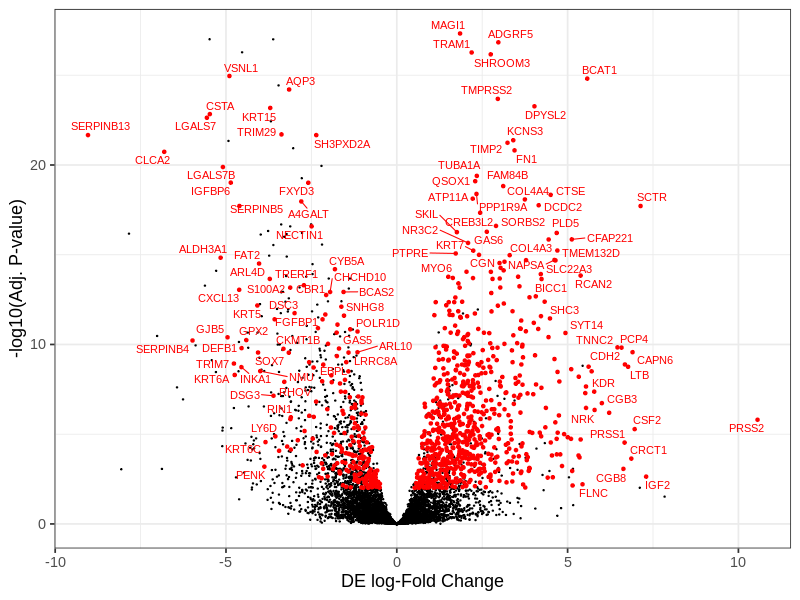

In [95]:
%%R -i DE_Basaloid_vs_KRT17hi -w 800 -h 600
max_lfc = 15
DE_Basaloid_vs_KRT17hi$lfc <- ifelse(abs(DE_Basaloid_vs_KRT17hi$lfc) > max_lfc, sign(DE_Basaloid_vs_KRT17hi$lfc) * Inf, DE_Basaloid_vs_KRT17hi$lfc)
DE_Basaloid_vs_KRT17hi %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif  & !is.na(signif_vs_normal), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(size=0.5) +
    geom_point(data=. %>% filter(!is.na(label)), color='red') +
    ggrepel::geom_text_repel(aes(label=label), color='red') +
    theme_bw(base_size=18) +
    xlab("DE log-Fold Change") +
    ylab('-log10(Adj. P-value)') 

Get markers from other studies

In [96]:
basaloid_markers_adams = 'EPCAM CDH1 VIM FN1 COL1A1 CDH2 TNC VCAN PCP4 CUX2 SPINK1 PRSS2 CPA6 CTSE MMP7 MDK GDF15 PTGS2 SLCO2A1 EPHB2 ITGB8 ITGAV ITGB6 TGFBI KCNN4 KCNQ5 KCNS3 CDKN1A CDKN2A CDKN2B CCND1 CCND2 MDM2 HMGA2 PTCHD4 OCIAD2'
basaloid_markers_adams = basaloid_markers_adams.split(' ')
## From fig4H 
basaloid_markers_habermann = ['SOX9', 'SOX4', 'HOPX', 'NAPSA', 'NKX2-1', 'CDH2', 'VIM', 'GDF15', 'CDKN2A', 'ITGAV', 'ITGB6', 'MDK',  'MMP7', "TM4SF1", 'COL1A1', "FN1"]
basaloid_markers_lang = ['LAMC2', 'CDH2', 'CDKN1A', 'CDKN1B', 'TNFRSF12A',
                         'MDK', 'CDH1', 'DSG2', 'ADAM9', 'AGRN'
                        ]

## from https://www.nature.com/articles/s41467-022-33193-0/figures/1
KRT17hi_markers_Jaeger2022 = ['KRT17', 'KLF4', 'AREG', "CTGF", 'ADAM9', "ITGB8", 'ITGB6', 'HBEGF', 'CD24', 'KRT6A', 'ADAM17', "MMP7"]

basaloid_markers = basaloid_markers_adams + basaloid_markers_habermann + basaloid_markers_lang
KRT17hi_markers = KRT17hi_markers_Jaeger2022
# pd.Series(keep_genes)[pd.Series(keep_genes).isin(KRT17hi_markers_Jaeger2022)]
# pd.Series(keep_genes)[pd.Series(keep_genes).isin(basaloid_markers_habermann)]

Get drug targets for lung disease (EFO_0003818)

In [108]:
drug_targets_df_lung_disease = pd.read_table("./EFO_0003818-associated-diseases.tsv")
drug_targets_df_lung_disease

,symbol,overallAssociationScore,geneticAssociations,somaticMutations,drugs,pathwaysSystemsBiology,textMining,rnaExpression,animalModels,targetName
0,ADRB2,0.679821,No data,No data,0.999085,0.8052120724080466,0.8333034948802764,No data,No data,adrenoceptor beta 2
1,CHRM3,0.707047,0.49190115984955285,No data,0.998899,0.7098525922470418,0.13818606439521208,No data,No data,cholinergic receptor muscarinic 3
2,NR3C1,0.714419,0.5073176798253137,No data,0.998488,0.607930797611621,0.8691521912218312,No data,0.6511442766525414,nuclear receptor subfamily 3 group C member 1
3,TUBB4B,0.684326,No data,No data,0.996086,0.6701930029382914,No data,No data,No data,tubulin beta 4B class IVb
4,TUBB,0.628388,0.11529217759110483,No data,0.996086,No data,0.3933734123537556,No data,No data,tubulin beta class I
...,...,...,...,...,...,...,...,...,...,...
642,XPNPEP2,0.038529,No data,No data,0.060793,No data,0.051674117796987794,No data,No data,X-prolyl aminopeptidase 2
643,NOTCH2,0.593411,No data,0.8521605384891806,0.030397,0.865457038266544,0.6243409366688295,No data,No data,notch receptor 2
644,PTGER4,0.180799,0.27194806497376406,No data,0.030397,No data,0.11494100824691857,No data,0.4127546150384101,prostaglandin E receptor 4
645,NOTCH3,0.291281,No data,No data,0.030397,0.865457038266544,0.8605871772032982,No data,No data,notch receptor 3


Make table for figure

In [111]:
from scipy.sparse import csr_matrix
def get_frac_expressing(adata, groupby, var_names, stat='frac'):
    X_expr = adata[:, var_names].X.copy()
    if stat=='frac':
        X_expr[X_expr.nonzero()] = 1

    groups = pd.get_dummies(adata.obs[groupby])
    n_groups  = groups.sum()
    n_expressing = X_expr.T.dot(csr_matrix(groups.values))
    n_expressing = pd.DataFrame(n_expressing.toarray(), 
                 columns=groups.columns, 
                 index = var_names
                )
    frac_expressing = n_expressing / n_groups
    return(frac_expressing)

## Keep genes if significant or known markers
keep_genes = DE_signif['gene_name'].unique().tolist() + basaloid_markers + KRT17hi_markers

## Compute fraction of cells in group expressing gene and mean expression
frac_expressing = get_frac_expressing(acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'])], 'nhood_groups', var_names=keep_genes).reset_index()
frac_expressing.columns = ['gene_name'] + frac_expressing.columns[1:].tolist()
mean_expressing = get_frac_expressing(acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'])], 'nhood_groups', var_names=keep_genes, stat='mean').reset_index()
mean_expressing.columns = ['gene_name'] + mean_expressing.columns[1:].tolist()

mean_expressing = mean_expressing.melt('gene_name', var_name='group', value_name='mean_expression')
frac_expressing = frac_expressing.melt('gene_name', var_name='group', value_name='frac_expressing')

dotplot_df = pd.merge(frac_expressing, mean_expressing)
DE_signif.index.name = 'index'
dotplot_df = pd.merge(dotplot_df, DE_signif[['gene_name', 'lfc', 'signif']], how='left')

## Save info on markers
dotplot_df['known_basaloid_marker'] = dotplot_df['gene_name'].isin(basaloid_markers)
dotplot_df['known_KRT17hi_marker'] = dotplot_df['gene_name'].isin(KRT17hi_markers)

## Save info on drug targets
dotplot_df['drug_target'] = dotplot_df['gene_name'].isin(DE_signif.index[DE_signif.drug_targets])
dotplot_df['drug_target_all'] = dotplot_df['gene_name'].isin(drug_targets_df_lung_disease['symbol'])

## Save info on genetics evidence
dotplot_df['GWAS_evidence'] = dotplot_df['gene_name'].isin(DE_signif.index[DE_signif.GWAS_evidence])

In [112]:
dotplot_df

,gene_name,group,frac_expressing,mean_expression,lfc,signif,known_basaloid_marker,known_KRT17hi_marker,drug_target,drug_target_all,GWAS_evidence
0,SERPINB13,Normal_basal,0.100512,0.114845,-9.039401,enr_KRT17hi,False,False,False,False,False
1,CLCA2,Normal_basal,0.114597,0.136592,-6.807423,enr_KRT17hi,False,False,False,False,False
2,SERPINB4,Normal_basal,0.058899,0.070368,-5.979008,enr_KRT17hi,False,False,False,False,False
3,LGALS7,Normal_basal,0.133803,0.144037,-5.558895,enr_KRT17hi,False,False,False,False,False
4,CSTA,Normal_basal,0.130602,0.125701,-5.472791,enr_KRT17hi,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
3610,KRT17,Basaloid,0.955556,3.168634,NaN,NaN,False,True,False,False,False
3611,KLF4,Basaloid,0.466667,0.439885,NaN,NaN,False,True,False,False,False
3612,CTGF,Basaloid,0.577778,0.750064,NaN,NaN,False,True,False,False,False
3613,HBEGF,Basaloid,0.400000,0.282904,NaN,NaN,False,True,False,False,False


In [113]:
%%R -i dotplot_df
dotplot_df %>%
head(10)


  gene_name        group frac_expressing mean_expression       lfc      signif
0 SERPINB13 Normal_basal      0.10051216      0.11484491 -9.039401 enr_KRT17hi
1     CLCA2 Normal_basal      0.11459667      0.13659207 -6.807423 enr_KRT17hi
2  SERPINB4 Normal_basal      0.05889885      0.07036751 -5.979008 enr_KRT17hi
3    LGALS7 Normal_basal      0.13380282      0.14403721 -5.558895 enr_KRT17hi
4      CSTA Normal_basal      0.13060179      0.12570102 -5.472791 enr_KRT17hi
5   ALDH3A1 Normal_basal      0.17093470      0.20625041 -5.156967 enr_KRT17hi
6   LGALS7B Normal_basal      0.28040973      0.38275991 -5.090279 enr_KRT17hi
7      GJB5 Normal_basal      0.02816901      0.01744855 -4.954022 enr_KRT17hi
8     VSNL1 Normal_basal      0.13828425      0.15614592 -4.900418 enr_KRT17hi
9    IGFBP6 Normal_basal      0.18053777      0.22591241 -4.859640 enr_KRT17hi
  known_basaloid_marker known_KRT17hi_marker drug_target drug_target_all
0                 FALSE                FALSE       FALSE  

Plot all with known markers

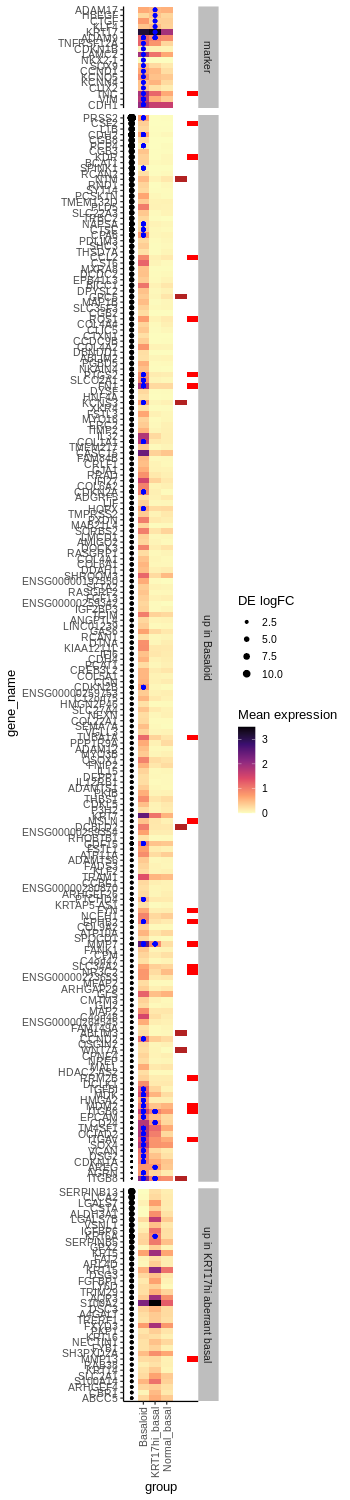

In [134]:
%%R -h 1500 -w 350 -o keep_DE_genes
## Keep genes if expressed in >20% of cells in group, log-Fold change > 2 and mean expression > 0.2
keep_DE_genes <- dotplot_df %>%
    filter(
        frac_expressing > 0.2 & 
           abs(lfc) > 2 &
           mean_expression > 0.2
    ) %>%
    distinct(lfc, gene_name, signif) %>%
    pull(gene_name) %>%
    unique()

pl_df <- dotplot_df %>%
    mutate(signif = factor(ifelse(is.na(signif), 'marker', signif), levels=c('marker', 'enr_Basaloid', 'enr_KRT17hi'))) %>%
    filter(gene_name %in% keep_DE_genes | known_KRT17hi_marker | known_basaloid_marker) %>%
    arrange(abs(lfc)) %>%
    mutate(gene_name = factor(gene_name, levels=unique(gene_name))) 

pl_df %>%
    ggplot(aes(group, gene_name, fill=mean_expression)) +
    geom_tile() +
    geom_point(data=. %>% filter(known_basaloid_marker), aes(x='Basaloid'), color='blue') +
    geom_point(data=. %>% filter(known_KRT17hi_marker), aes(x='KRT17hi_basal'), color='blue') +
    geom_tile(data=. %>% filter(GWAS_evidence), aes(x=4.2), fill='firebrick') +
    geom_tile(data=. %>% filter(drug_target_all), aes(x=5.2), fill='red') +
    geom_tile(data=. %>% filter(drug_target), aes(x=-0.2), fill=NA) +
    geom_point(data=. %>% filter(signif != 'marker'), aes(x=0, size=abs(lfc))) +
    theme_classic(base_size=13) +
    scale_size(range = c(0,3), name='DE logFC') +
    scale_fill_viridis_c(option='magma', direction=-1, name='Mean expression') +
    facet_grid(signif~., scales='free', space='free',
               labeller = labeller(signif = c(marker='marker', enr_Basaloid='up in Basaloid', enr_KRT17hi = 'up in KRT17hi aberrant basal')) 
              ) +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), strip.background=element_rect(fill='grey', color=NA)) +
    ggsave(paste0(figdir, 'DE_basal_heatmap_full.pdf'), height=28, width=5)

# pl_df %>%
# ggplot(aes(1, gene_name, fill=GWAS_evidence)) +
# geom_tile() +
# theme_classic(base_size=14) +
# facet_grid(signif~., scales='free', space='free')

Plot for main figure (filter novel markers)

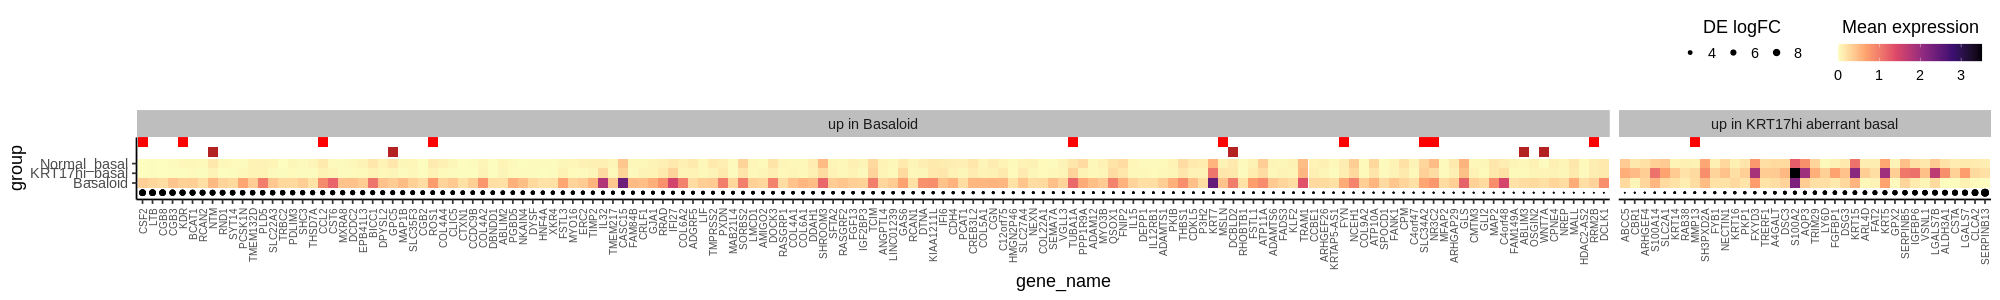

In [171]:
%%R -w 2000 -h 300 -o keep_DE_genes
## Keep genes if expressed in >20% of cells in group, log-Fold change > 2 and mean expression > 0.2
keep_DE_genes <- dotplot_df %>%
    filter(
        frac_expressing > 0.2 & 
           abs(lfc) > 2 &
           mean_expression > 0.2
    ) %>%
    distinct(lfc, gene_name, signif) %>%
#     group_by(signif) %>%
#     top_n(100, abs(lfc)) %>% ## Top 100 genes ranked by lfc
    pull(gene_name) %>%
    unique()

pl_df <- dotplot_df %>%
    mutate(signif = factor(ifelse(is.na(signif), 'marker', signif), levels=c('marker', 'enr_Basaloid', 'enr_KRT17hi'))) %>%
    filter(!known_basaloid_marker) %>%
    filter(!known_KRT17hi_marker) %>%
    filter(gene_name %in% keep_DE_genes) %>%
    filter(!str_detect(gene_name, '^ENSG')) %>%
    arrange(- lfc) %>%
    mutate(gene_name = factor(gene_name, levels=unique(gene_name))) 

pl_df %>%
    ggplot(aes(group, gene_name, fill=mean_expression)) +
    geom_tile() +
#     geom_point(data=. %>% filter(known_basaloid_marker), aes(x='Basaloid'), color='blue') +
#     geom_point(data=. %>% filter(known_KRT17hi_marker), aes(x='KRT17hi_basal'), color='blue') +
    geom_tile(data=. %>% filter(GWAS_evidence), aes(x=4.2), fill='firebrick') +
    geom_tile(data=. %>% filter(drug_target_all), aes(x=5.2), fill='red') +
    geom_tile(data=. %>% filter(drug_target_all), aes(x=-0.2), fill=NA) + # this is just a spacer
    geom_point(data=. %>% filter(signif != 'marker'), aes(x=0, size=abs(lfc))) +
    theme_classic(base_size=18) +
    coord_flip() +
    scale_size(range = c(0,3), name='DE logFC') +
    scale_fill_viridis_c(option='magma', direction=-1, name='Mean expression') +
    facet_grid(.~signif, scales='free', space='free',
               labeller = labeller(signif = c(marker='marker', enr_Basaloid='up in Basaloid', enr_KRT17hi = 'up in KRT17hi aberrant basal')) 
              ) +
    guides(fill = guide_colourbar(title.position="top", title.hjust = 0.5, barwidth=10),
         size = guide_legend(title.position="top", title.hjust = 0.5)) +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5, size=10), 
          strip.background=element_rect(fill='grey', color=NA),
          legend.position='top', legend.justification = "right"
         ) +
    ggsave(paste0(figdir, 'DE_basal_heatmap_fig.pdf'), height=5, width=25)

In [135]:
target_genes = drug_targets_df_lung_disease['symbol'][drug_targets_df_lung_disease['symbol'].isin(DE_signif.gene_name)]
DE_signif[DE_signif.gene_name.isin(target_genes)]

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,signif,signif_vs_normal,drug_targets,GWAS_evidence
index,,,,,,,,,,,
MMP13,1.339138e-05,9.703901e-05,19.619115,1,291.127484,-2.346574,MMP13,enr_KRT17hi,enr_KRT17hi,False,False
GPNMB,8.755861e-07,8.539527e-06,25.261700,1,291.127484,-1.837448,GPNMB,enr_KRT17hi,enr_KRT17hi,False,False
IMPDH2,1.541823e-11,4.430527e-10,49.315449,1,291.127484,-1.753601,IMPDH2,enr_KRT17hi,enr_KRT17hi,False,False
NDUFA8,2.563582e-09,4.399740e-08,37.812121,1,291.127484,-1.509688,NDUFA8,enr_KRT17hi,enr_KRT17hi,False,False
NDUFB5,2.356686e-03,8.972154e-03,9.413497,1,291.127484,-0.723119,NDUFB5,enr_KRT17hi,enr_KRT17hi,False,False
NDUFB6,6.785790e-04,3.067416e-03,11.799658,1,291.127484,-0.709670,NDUFB6,enr_KRT17hi,enr_KRT17hi,False,False
NDUFB11,2.151564e-03,8.374015e-03,9.586105,1,291.127484,-0.541225,NDUFB11,enr_KRT17hi,enr_KRT17hi,False,False
NDUFB9,3.272206e-04,1.617768e-03,13.221303,1,291.127484,0.595113,NDUFB9,enr_Basaloid,enr_Basaloid,False,False
ERBB3,1.829922e-03,7.257756e-03,9.893821,1,291.127484,0.646016,ERBB3,enr_Basaloid,enr_Basaloid,False,False


### Plot enrichment results

In [188]:
enr_KRT17hi = pd.concat([
    pd.read_table('./enrichr/enr_KRT17hi/GO_Biological_Process_2017.Human.enrichr.reports.txt'),
    pd.read_table('./enrichr/enr_KRT17hi/MSigDB_Hallmark_2020.Human.enrichr.reports.txt')
])
enr_KRT17hi = enr_KRT17hi[enr_KRT17hi['Adjusted P-value'] < 0.1]
enr_KRT17hi['top10_genes'] = [';'.join(x[0:10]) for x in enr_KRT17hi['Genes'].str.split(";")]

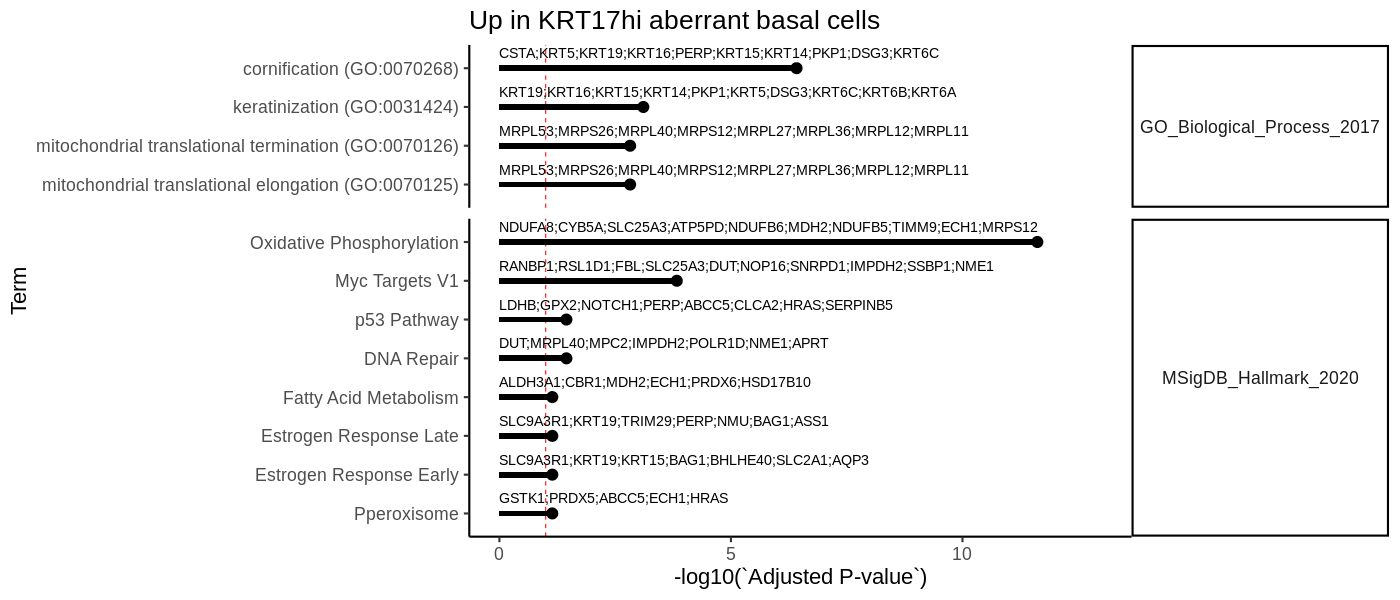

In [201]:
%%R -i enr_KRT17hi -w 1400 -h 600
enr_KRT17hi %>%
arrange(- `Adjusted P-value`) %>%
mutate(Term = factor(Term, levels=Term)) %>%
ggplot(aes(-log10(`Adjusted P-value`), Term)) +
geom_vline(xintercept=1, linetype=2, color='red') +
geom_col(width=0.15, fill='black') +
geom_point(size=5) +
geom_text(aes(x=0, label=top10_genes), size = 5, vjust=-1, hjust=0) +
xlim(0,13) +
theme_classic(base_size=22) +
facet_grid(Gene_set~., scales='free', space='free') +
theme(strip.text.y = element_text(angle=0)) +
ggtitle('Up in KRT17hi aberrant basal cells') +
ggsave(paste0(figdir, 'enr_analysis_KRT17hi.pdf'), width=18, height=8)

In [194]:
enr_Basaloid = pd.concat([
    pd.read_table('./enrichr/enr_Basaloid/GO_Biological_Process_2017.Human.enrichr.reports.txt'),
    pd.read_table('./enrichr/enr_Basaloid/MSigDB_Hallmark_2020.Human.enrichr.reports.txt')
])
enr_Basaloid = enr_Basaloid[enr_Basaloid['Adjusted P-value'] < 0.05]
enr_Basaloid['top10_genes'] = [';'.join(x[0:10]) for x in enr_Basaloid['Genes'].str.split(";")]

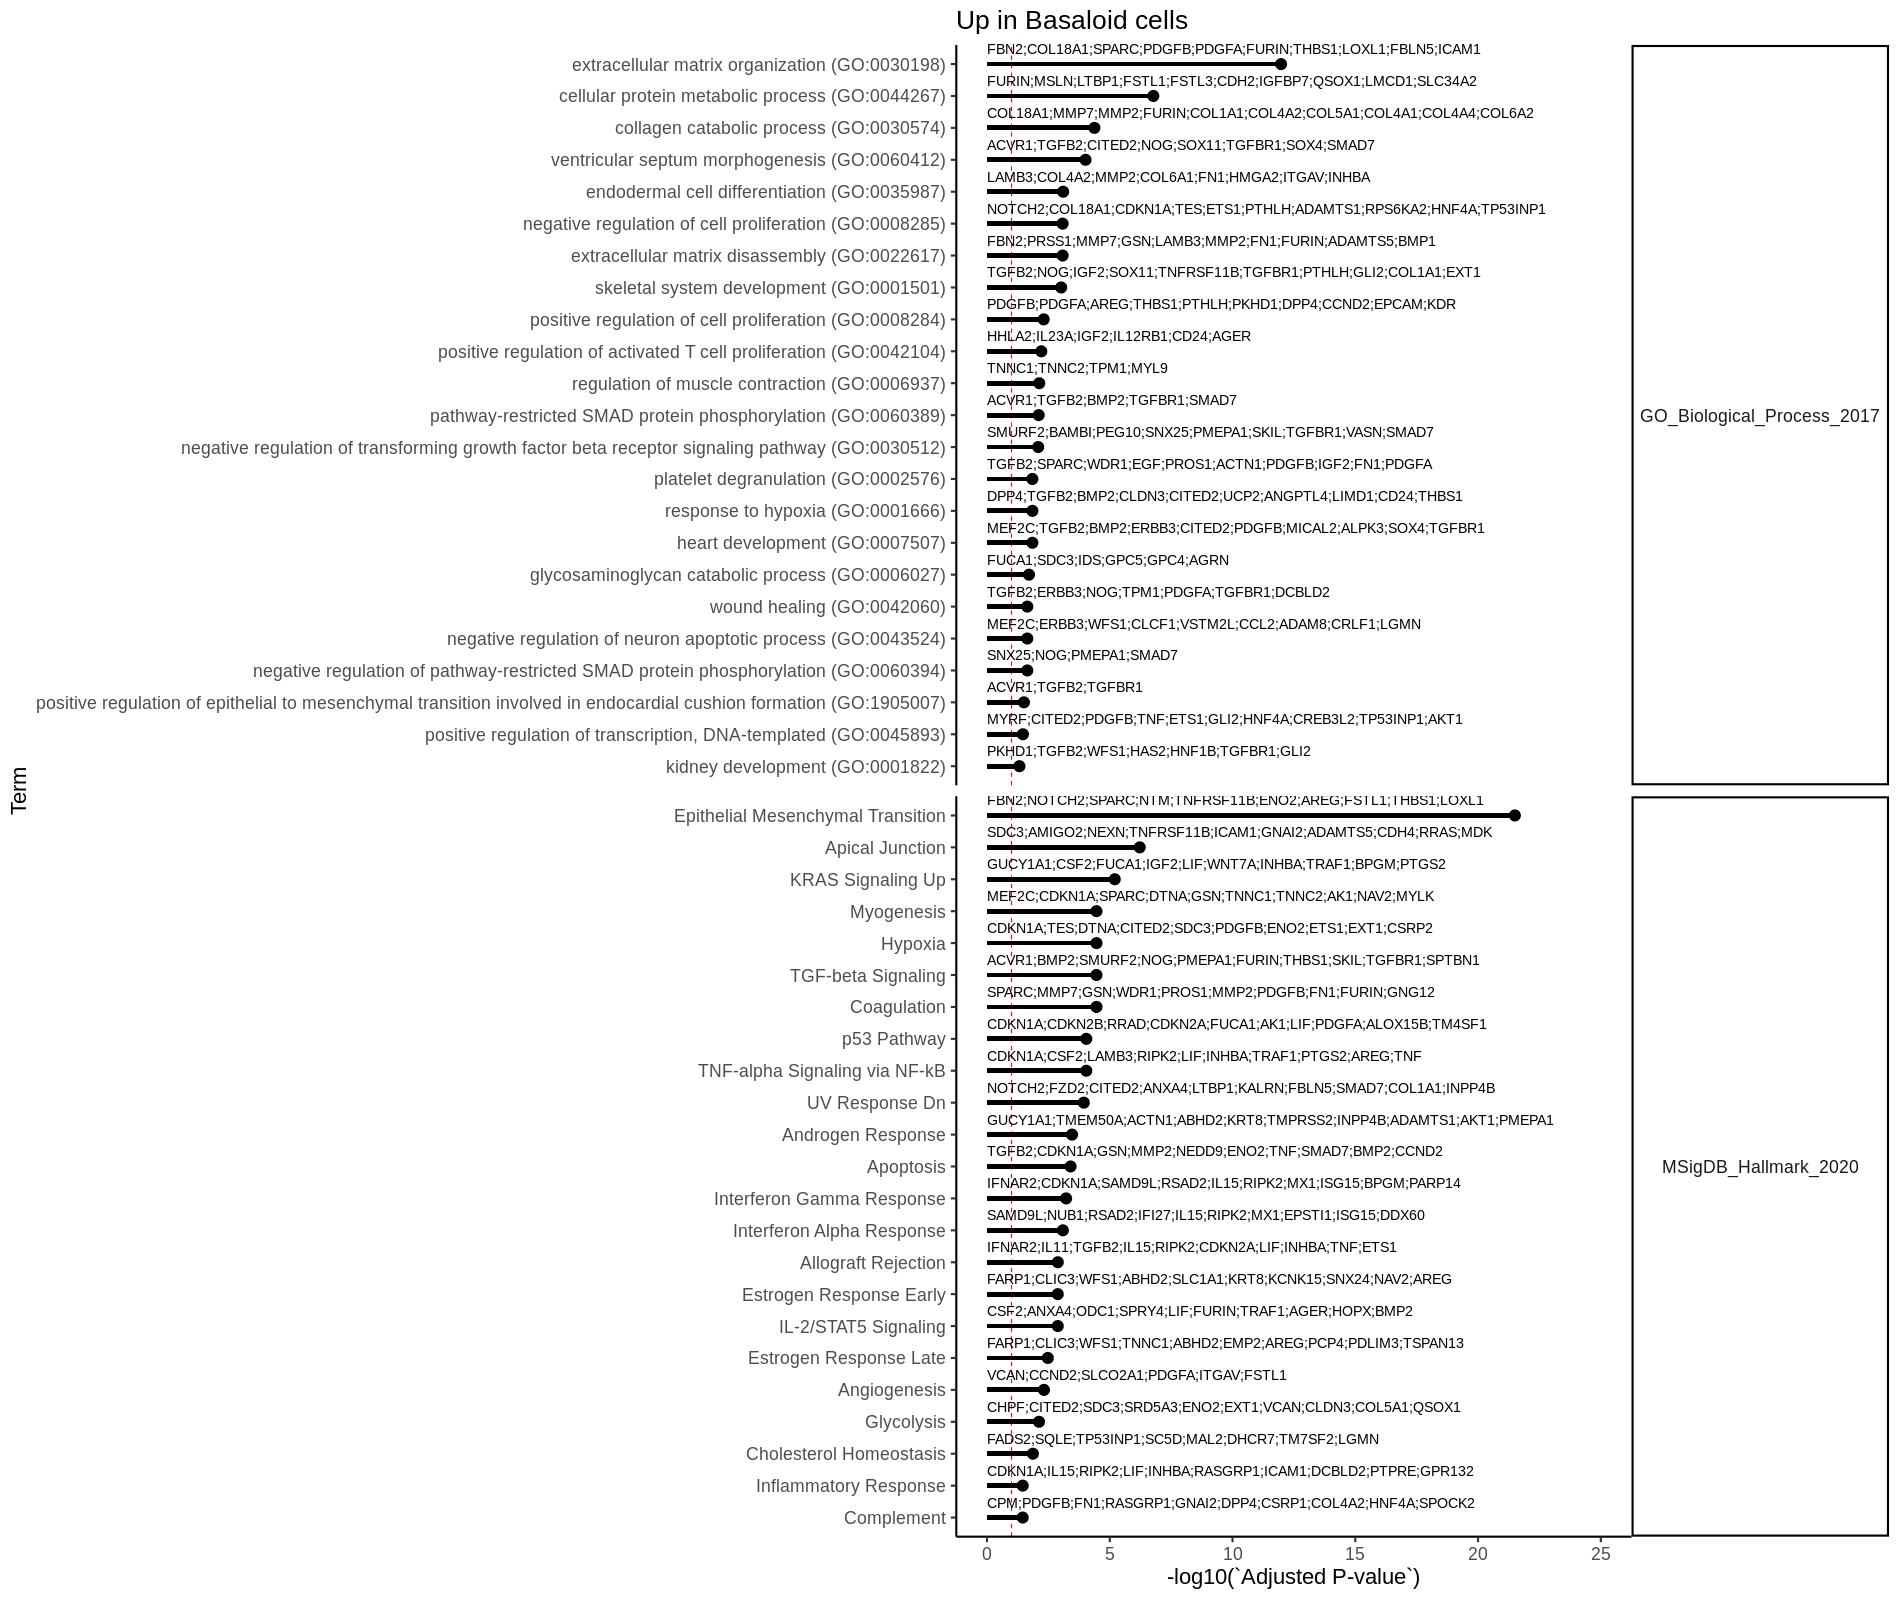

In [200]:
%%R -i enr_Basaloid -w 1900 -h 1600 
enr_Basaloid %>%
arrange(- `Adjusted P-value`) %>%
mutate(Term = factor(Term, levels=Term)) %>%
ggplot(aes(-log10(`Adjusted P-value`), Term)) +
geom_vline(xintercept=1, linetype=2, color='red') +
geom_col(width=0.15, fill='black') +
geom_point(size=5) +
geom_text(aes(x=0, label=top10_genes), size=5, vjust=-1, hjust=0) +
xlim(0,25) +
theme_classic(base_size=22) +
facet_grid(Gene_set~., scales='free', space='free') +
theme(strip.text.y = element_text(angle=0)) +
ggtitle("Up in Basaloid cells") +
ggsave(paste0(figdir, 'enr_analysis_Basaloid.pdf'), width=26, height=20)

### Prep suppl table with DE analysis results

In [185]:
DE_Basaloid_vs_KRT17hi = pd.read_csv(data_dir + '/DE_Basaloid_vs_KRT17hi.csv', index_col=0)
DE_Basaloid_vs_KRT17hi.index = DE_Basaloid_vs_KRT17hi.gene_name

## Save info on markers
DE_Basaloid_vs_KRT17hi['known_basaloid_marker'] = DE_Basaloid_vs_KRT17hi['gene_name'].isin(basaloid_markers)
DE_Basaloid_vs_KRT17hi['known_KRT17hi_marker'] = DE_Basaloid_vs_KRT17hi['gene_name'].isin(KRT17hi_markers)

## Save info on drug targets
DE_Basaloid_vs_KRT17hi['drug_target_lung_disease'] = DE_Basaloid_vs_KRT17hi['gene_name'].isin(drug_targets_df_lung_disease['symbol'])

## Save info on genetics evidence
DE_Basaloid_vs_KRT17hi['GWAS_evidence'] = DE_Basaloid_vs_KRT17hi['gene_name'].isin(DE_Basaloid_vs_KRT17hi.index[DE_Basaloid_vs_KRT17hi.GWAS_evidence])

DE_Basaloid_vs_KRT17hi['overexpressed_vs_normal'] = ~DE_Basaloid_vs_KRT17hi['signif_vs_normal'].isna()

DE_Basaloid_vs_KRT17hi = DE_Basaloid_vs_KRT17hi.drop(['drug_targets', 'signif_vs_normal'], 1)

/tmp/ipykernel_31146/3938314480.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  DE_Basaloid_vs_KRT17hi = DE_Basaloid_vs_KRT17hi.drop(['drug_targets', 'signif_vs_normal'], 1)


In [187]:
DE_Basaloid_vs_KRT17hi.to_csv('/home/jovyan/mount/gdrive/diff2atlas/suppl_table_DEbasal.csv')

---